<a href="https://colab.research.google.com/github/mahadkhaliq/ecg_processing/blob/main/ecg_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = 'ecg_2nd.csv'
ecg_data = pd.read_csv(file_path)

# Display the first few rows of the dataset and the columns to understand its structure
ecg_data.head(), ecg_data.columns


(   time_ms  ecg_signal  beats heartbeat  R_peak
 0    0.000       301.0    NaN       NaN     NaN
 1    9.795       239.0    NaN       NaN     NaN
 2   10.922       169.0    NaN       NaN     NaN
 3   12.667       242.0    NaN       NaN     NaN
 4   14.167       330.0    NaN       NaN     NaN,
 Index(['time_ms', 'ecg_signal', 'beats', 'heartbeat', 'R_peak'], dtype='object'))

In [ ]:
# Check for non-null entries in 'R_peak' and 'heartbeat' to identify useful segments
ecg_non_null = ecg_data.dropna(subset=['R_peak', 'heartbeat'], how='all')
ecg_non_null.head(), ecg_non_null.describe()


(     time_ms  ecg_signal  beats    heartbeat  R_peak
 192  211.266       212.0    NaN  Tachycardia     NaN
 193  211.554       271.0    NaN  Tachycardia     NaN
 194  212.908       199.0    NaN  Tachycardia     NaN
 195  214.262       135.0    NaN  Tachycardia     NaN
 196  214.575       211.0    NaN  Tachycardia     NaN,
              time_ms    ecg_signal  beats  R_peak
 count   70829.000000  70829.000000    0.0     0.0
 mean   262688.115784    277.304353    NaN     NaN
 std    157056.699541    197.439571    NaN     NaN
 min       211.266000   -343.000000    NaN     NaN
 25%    127238.391000    189.000000    NaN     NaN
 50%    257301.540000    251.000000    NaN     NaN
 75%    395379.387000    321.000000    NaN     NaN
 max    550739.399000   1570.000000    NaN     NaN)

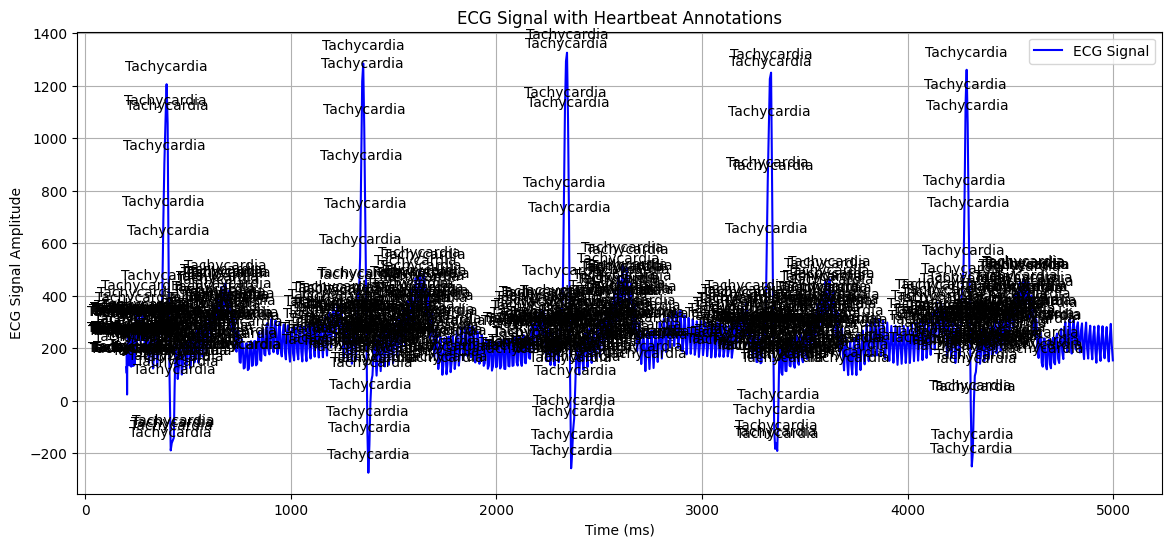

In [ ]:
import matplotlib.pyplot as plt

t_s = 200 #start time
t_e = 5000 #end time
# Filter the data for a smaller segment to plot, focusing on where we have heartbeat annotations
segment = ecg_data[(ecg_data['time_ms'] >= t_s) & (ecg_data['time_ms'] <= t_e)]

# Plotting the ECG signal
plt.figure(figsize=(14, 6))
plt.plot(segment['time_ms'], segment['ecg_signal'], label='ECG Signal', color='b')

# Annotate heartbeats
for idx, row in segment[segment['heartbeat'].notnull()].iterrows():
    plt.annotate(row['heartbeat'], (row['time_ms'], row['ecg_signal']), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('ECG Signal with Heartbeat Annotations')
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


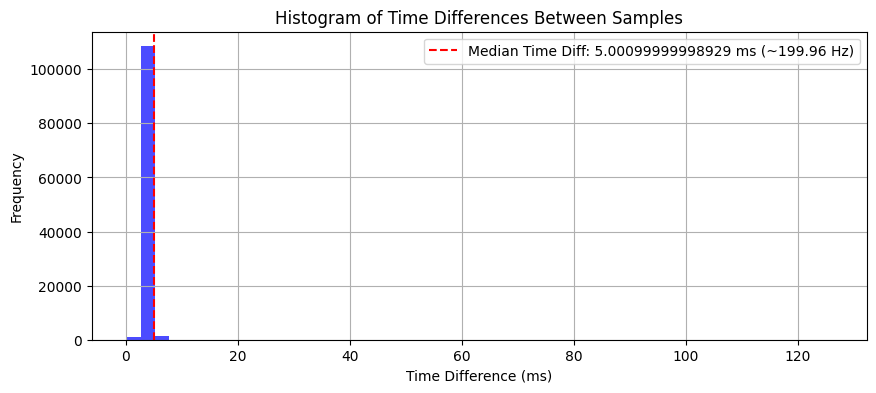

199.96000799882856

In [ ]:
# Calculate the differences between successive time points to estimate the sampling frequency
time_diffs = np.diff(ecg_data['time_ms'])
sampling_rate_estimate = 1000 / np.median(time_diffs)  # Convert time differences to frequency in Hz

# Plot the distribution of time differences to inspect stability
plt.figure(figsize=(10, 4))
plt.hist(time_diffs, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Time Differences Between Samples')
plt.xlabel('Time Difference (ms)')
plt.ylabel('Frequency')
plt.axvline(x=np.median(time_diffs), color='r', linestyle='--', label=f'Median Time Diff: {np.median(time_diffs)} ms (~{sampling_rate_estimate:.2f} Hz)')
plt.legend()
plt.grid(True)
plt.show()

sampling_rate_estimate



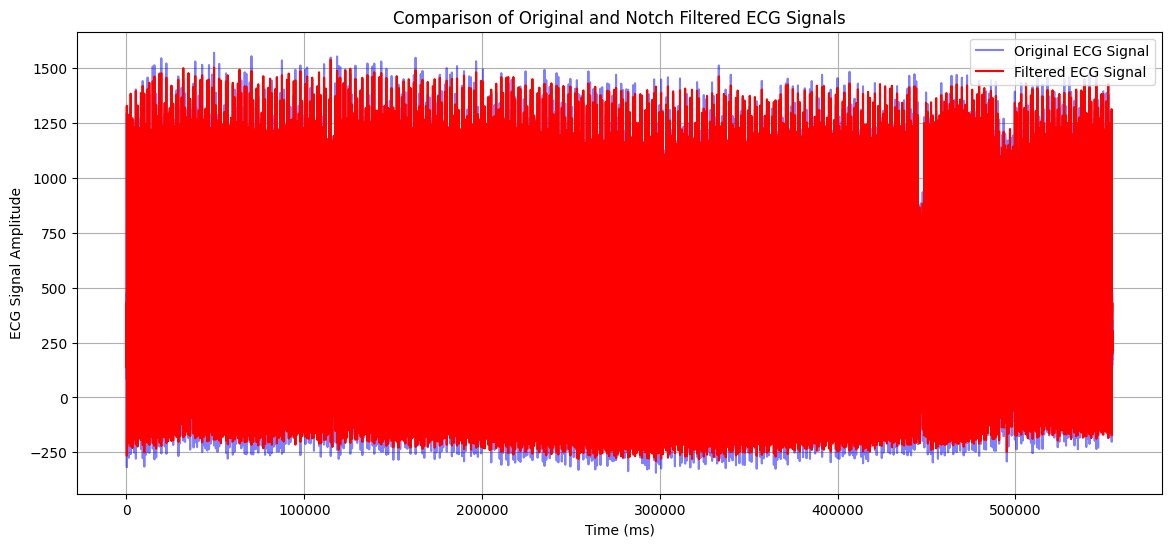

In [ ]:
from scipy.signal import iirnotch, filtfilt

# Define the notch filter parameters
notch_freq = 50  # frequency to be notched out, in Hz
quality_factor = 30  # Quality factor for the notch filter

# Calculate the notch filter coefficients
b_notch, a_notch = iirnotch(notch_freq, quality_factor, sampling_rate_estimate)

# Apply the notch filter to the signal
filtered_signal = filtfilt(b_notch, a_notch, ecg_data['ecg_signal'].values)

# Update the DataFrame with the filtered signal for plotting and peak detection
ecg_data['filtered_signal'] = filtered_signal

# Plot the original and the filtered signals for comparison
plt.figure(figsize=(14, 6))
plt.plot(ecg_data['time_ms'], ecg_data['ecg_signal'], label='Original ECG Signal', color='b', alpha=0.5)
plt.plot(ecg_data['time_ms'], ecg_data['filtered_signal'], label='Filtered ECG Signal', color='r')
plt.title('Comparison of Original and Notch Filtered ECG Signals')
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


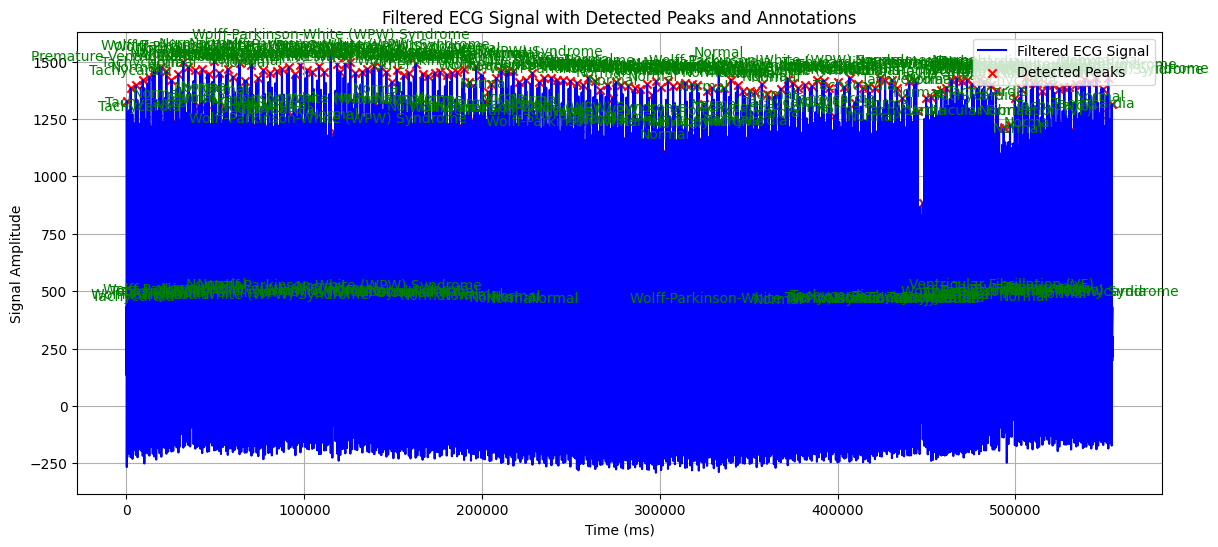

In [ ]:
from scipy.signal import find_peaks

# Detect peaks in the filtered signal with tuned parameters
peak_indices, _ = find_peaks(ecg_data['filtered_signal'], height=np.mean(ecg_data['filtered_signal']) + np.std(ecg_data['filtered_signal']) * 0.75, distance=200)

# Update the DataFrame to include the detected peaks
ecg_data['peak'] = 0
ecg_data.loc[peak_indices, 'peak'] = 1

# Plotting the filtered ECG signal with detected peaks and annotations
plt.figure(figsize=(14, 6))
plt.plot(ecg_data['time_ms'], ecg_data['filtered_signal'], label='Filtered ECG Signal', color='b')
plt.scatter(ecg_data['time_ms'][ecg_data['peak'] == 1], ecg_data['filtered_signal'][ecg_data['peak'] == 1], color='r', label='Detected Peaks', marker='x')

# Adding annotations for the detected peaks
for index in peak_indices:
    annotation = ecg_data.loc[index, 'heartbeat']
    if pd.notna(annotation):
        plt.annotate(annotation, (ecg_data.loc[index, 'time_ms'], ecg_data.loc[index, 'filtered_signal']), textcoords="offset points", xytext=(0,10), ha='center', color='green')

plt.title('Filtered ECG Signal with Detected Peaks and Annotations')
plt.xlabel('Time (ms)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# from scipy.signal import find_peaks
# import matplotlib.pyplot as plt
# import numpy as np

# # Detect peaks in the filtered signal with tuned parameters
# peak_indices, _ = find_peaks(ecg_data['filtered_signal'], height=np.mean(ecg_data['filtered_signal']) + np.std(ecg_data['filtered_signal']) * 0.75, distance=200)

# # Update the DataFrame to include the detected peaks
# ecg_data['peak'] = 0
# ecg_data.loc[peak_indices, 'peak'] = 1

# # Plotting the filtered ECG signal with detected peaks and annotations
# plt.figure(figsize=(14, 6))
# plt.plot(ecg_data['time_ms'], ecg_data['filtered_signal'], label='Filtered ECG Signal', color='b')
# plt.scatter(ecg_data['time_ms'][ecg_data['peak'] == 1], ecg_data['filtered_signal'][ecg_data['peak'] == 1], color='r', label='Detected Peaks', marker='x')

# # Adding annotations for the detected peaks
# for index in peak_indices:
#     annotation = ecg_data.loc[index, 'heartbeat']
#     if pd.notna(annotation):
#         plt.annotate(annotation, (ecg_data.loc[index, 'time_ms'], ecg_data.loc[index, 'filtered_signal']), textcoords="offset points", xytext=(0,10), ha='center', color='green')

# plt.title('Filtered ECG Signal with Detected Peaks and Annotations')
# plt.xlabel('Time (ms)')
# plt.ylabel('Signal Amplitude')
# plt.legend()
# plt.grid(True)

# # Set the ranges for the x and y axes
# plt.xlim(0, 5000)  # Set x-axis range from 0 to 5000 ms
# # plt.ylim(-2, 2)    # Set y-axis range from -2 to 2

# plt.show()

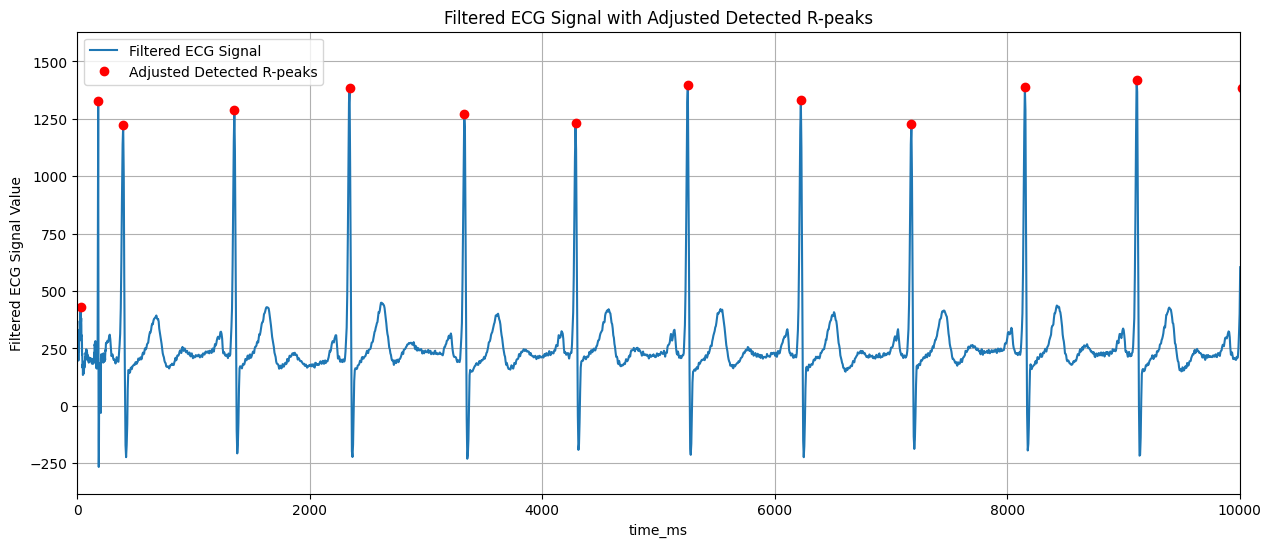

In [ ]:
filtered_signal = ecg_data['filtered_signal']
fs=200
# Adjusted parameters for peak detection

height_adjusted = np.mean(filtered_signal) + np.std(filtered_signal)  # Lowering the threshold
distance_adjusted = int(fs * 0.4)  # Reducing the minimum distance between R-peaks

# Find peaks with adjusted parameters
peaks_adjusted, _ = find_peaks(filtered_signal, height=height_adjusted, distance=distance_adjusted)

# Plotting the filtered ECG signal with adjusted detected peaks
plt.figure(figsize=(15, 6))
plt.plot(ecg_data['time_ms'], filtered_signal, label='Filtered ECG Signal')
plt.plot(ecg_data['time_ms'].iloc[peaks_adjusted], filtered_signal[peaks_adjusted], 'ro', label='Adjusted Detected R-peaks')
plt.title('Filtered ECG Signal with Adjusted Detected R-peaks')
plt.xlabel('time_ms')
plt.ylabel('Filtered ECG Signal Value')
plt.legend()
plt.grid(True)

plt.xlim(0, 10000)  # Set x-axis range from 0 to 5000 ms


plt.show()


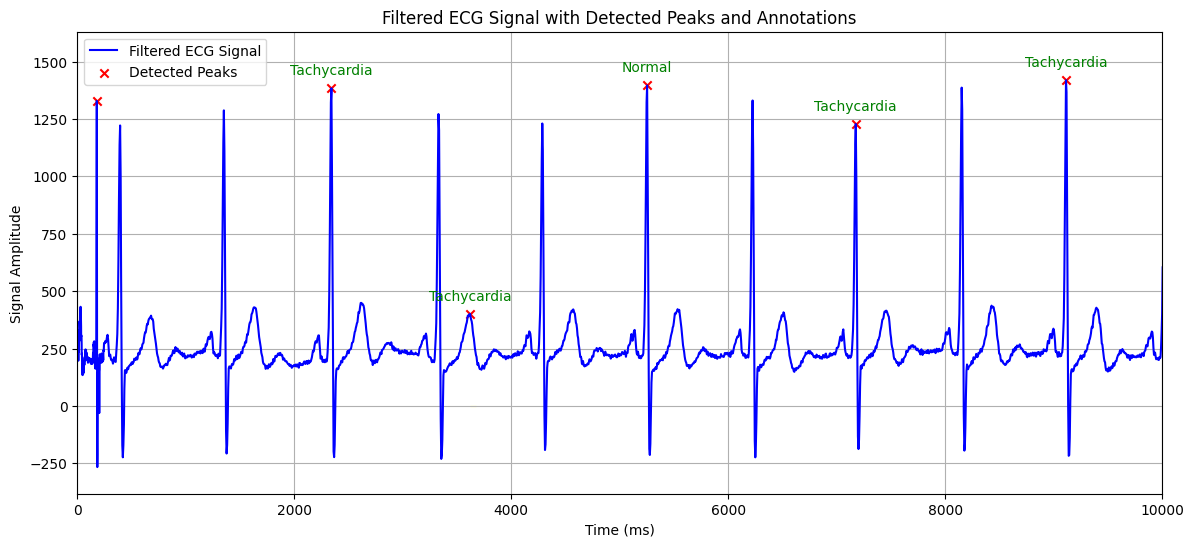

In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np

# Function to plot annotated segments under peaks
# Function to plot annotated segments under peaks
def plot_annotated_segments(ecg_data, peaks, segment_height=0.5, segment_color='yellow'):
    for peak_index in peaks:
        # Get the corresponding annotated segment
        segment = ecg_data.loc[peak_index, 'heartbeat']
        if pd.notna(segment) and segment != '':  # Check for NaN or empty values
            start_time = ecg_data.loc[peak_index, 'time_ms']
            end_time = start_time + len(segment) * (1000 / fs)  # Convert segment length to milliseconds
            plt.fill_betweenx(y=[segment_height - 0.1, segment_height + 0.1], x1=start_time, x2=end_time, color=segment_color, alpha=0.3)

# Detect peaks in the filtered signal with tuned parameters
peak_indices, _ = find_peaks(ecg_data['filtered_signal'], height=np.mean(ecg_data['filtered_signal']) + np.std(ecg_data['filtered_signal']) * 0.75, distance=200)

# Update the DataFrame to include the detected peaks
ecg_data['peak'] = 0
ecg_data.loc[peak_indices, 'peak'] = 1

# Plotting the filtered ECG signal with detected peaks and annotations
plt.figure(figsize=(14, 6))
plt.plot(ecg_data['time_ms'], ecg_data['filtered_signal'], label='Filtered ECG Signal', color='b')
plt.scatter(ecg_data['time_ms'][ecg_data['peak'] == 1], ecg_data['filtered_signal'][ecg_data['peak'] == 1], color='r', label='Detected Peaks', marker='x')

# Plot annotated segments under the peaks
plot_annotated_segments(ecg_data, peak_indices)

# Adding annotations for the detected peaks
for index in peak_indices:
    annotation = ecg_data.loc[index, 'heartbeat']
    if pd.notna(annotation):
        plt.annotate(annotation, (ecg_data.loc[index, 'time_ms'], ecg_data.loc[index, 'filtered_signal']), textcoords="offset points", xytext=(0,10), ha='center', color='green')

plt.title('Filtered ECG Signal with Detected Peaks and Annotations')
plt.xlabel('Time (ms)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)

plt.xlim(0, 10000)  # Set x-axis range from 0 to 5000 ms

plt.show()


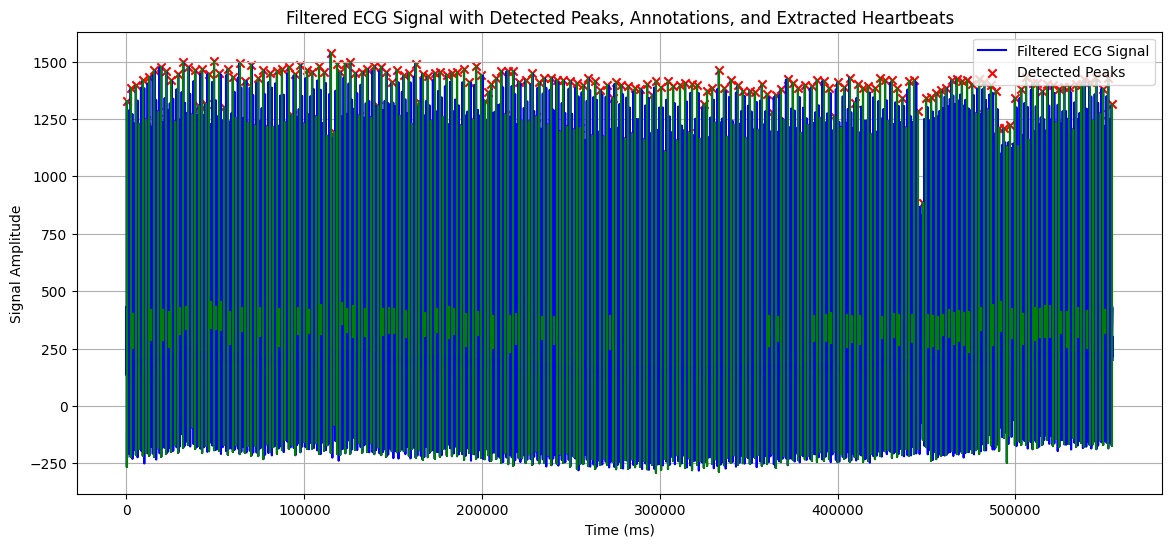

In [ ]:
# Function to extract heartbeats around R-peaks
def extract_heartbeats(ecg_data, peaks, window_size_ms=100):
    heartbeats = []
    window_size_samples = int(window_size_ms * (fs / 1000))  # Convert window size to samples
    for peak_index in peaks:
        # Ensure the window doesn't extend beyond the signal boundaries
        window_start = max(0, peak_index - window_size_samples // 2)
        window_end = min(len(ecg_data), peak_index + window_size_samples // 2)
        heartbeat = ecg_data['filtered_signal'][window_start:window_end]
        heartbeats.append(heartbeat)
    return heartbeats

# Extract heartbeats around detected R-peaks
heartbeats = extract_heartbeats(ecg_data, peak_indices)

# Plotting the filtered ECG signal with detected peaks and annotations
plt.figure(figsize=(14, 6))
plt.plot(ecg_data['time_ms'], ecg_data['filtered_signal'], label='Filtered ECG Signal', color='b')
plt.scatter(ecg_data['time_ms'][ecg_data['peak'] == 1], ecg_data['filtered_signal'][ecg_data['peak'] == 1], color='r', label='Detected Peaks', marker='x')

# Plot annotated segments under the peaks
plot_annotated_segments(ecg_data, peak_indices)

# Plot extracted heartbeats
for i, heartbeat in enumerate(heartbeats):
    peak_time = ecg_data.loc[peak_indices[i], 'time_ms']
    plt.plot(np.linspace(peak_time - 0.5, peak_time + 0.5, len(heartbeat)), heartbeat, color='green')

plt.title('Filtered ECG Signal with Detected Peaks, Annotations, and Extracted Heartbeats')
plt.xlabel('Time (ms)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Function to prepare training data
def prepare_training_data(ecg_data, peaks, window_size_samples=200):
    X = []  # Feature vectors (heartbeats)
    y = []  # Labels
    for peak_index in peaks:
        # Ensure the window doesn't extend beyond the signal boundaries
        window_start = max(0, peak_index - window_size_samples // 2)
        window_end = min(len(ecg_data), peak_index + window_size_samples // 2)
        heartbeat = ecg_data['filtered_signal'][window_start:window_end].values
        label = ecg_data.loc[peak_index, 'heartbeat']
        if pd.notna(label) and label != '':
            X.append(heartbeat)
            y.append(label)
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_training_data(ecg_data, peak_indices)

# Check the shape of the training data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (277, 200)
Shape of y_train: (277,)


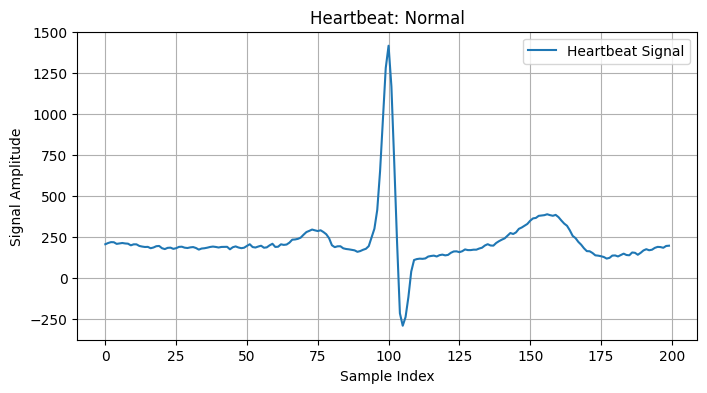

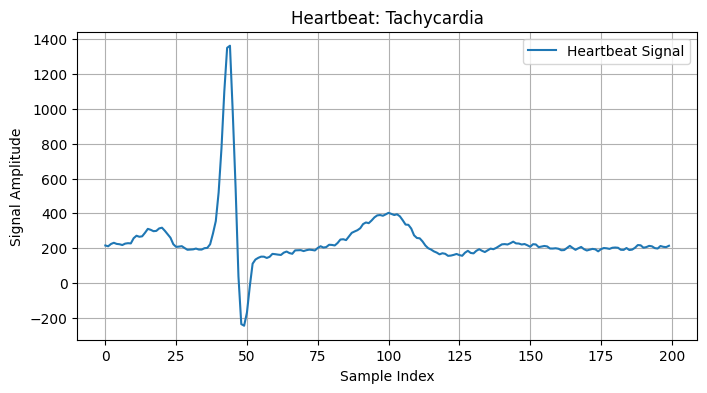

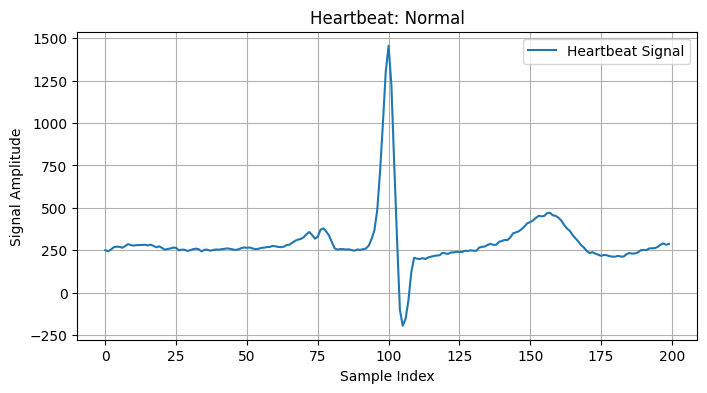

In [ ]:
import random

# Function to plot heartbeats
def plot_heartbeats(X, y, num_beats=3):
    indices = random.sample(range(len(X)), num_beats)  # Select random indices
    for idx in indices:
        plt.figure(figsize=(8, 4))
        plt.plot(X[idx], label='Heartbeat Signal')
        plt.title('Heartbeat: ' + y[idx])
        plt.xlabel('Sample Index')
        plt.ylabel('Signal Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot selected heartbeats
plot_heartbeats(X_train, y_train)



Unique Classes: ['Normal' 'Other' 'Premature Ventricular Contractions (PVCs)'
 'Tachycardia' 'Ventricular Fibrillation (VF)'
 'Wolff-Parkinson-White (WPW) Syndrome']


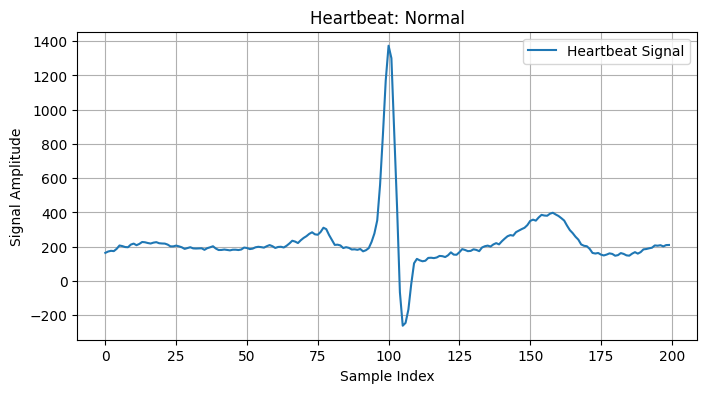

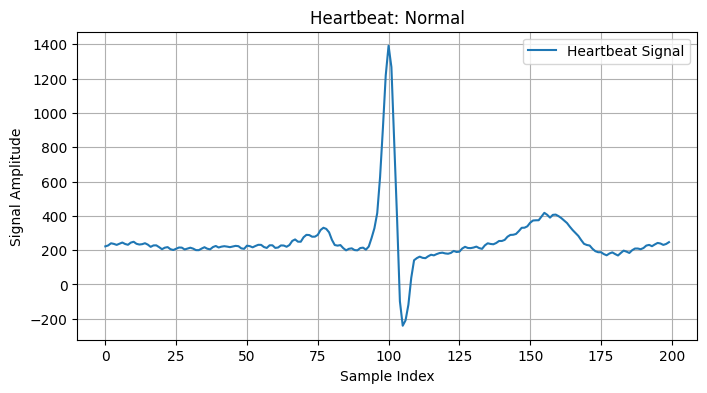

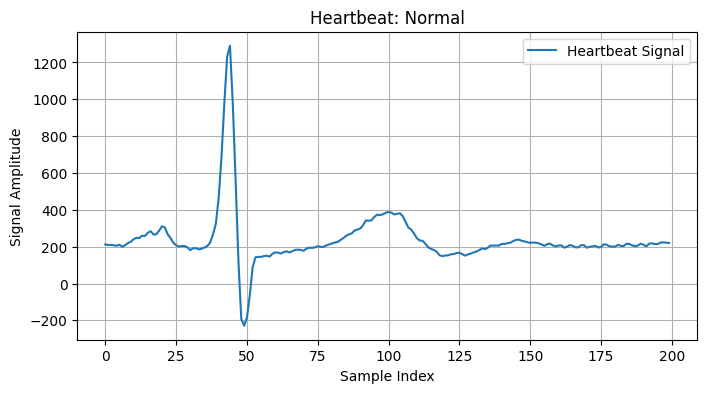

In [ ]:
import numpy as np

# Function to plot heartbeats and print unique classes
def plot_heartbeats(X, y, num_beats=3):
    unique_classes = np.unique(y)
    print("Unique Classes:", unique_classes)

    indices = random.sample(range(len(X)), num_beats)  # Select random indices
    for idx in indices:
        plt.figure(figsize=(8, 4))
        plt.plot(X[idx], label='Heartbeat Signal')
        plt.title('Heartbeat: ' + y[idx])
        plt.xlabel('Sample Index')
        plt.ylabel('Signal Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot selected heartbeats and print unique classes
plot_heartbeats(X_train, y_train)


In [ ]:
import numpy as np

# Function to print unique classes
def print_unique_classes(y):
    unique_classes = np.unique(y)
    print("Unique Classes:", unique_classes)

# Print unique classes
print_unique_classes(y_train)


Unique Classes: ['Normal' 'Other' 'Premature Ventricular Contractions (PVCs)'
 'Tachycardia' 'Ventricular Fibrillation (VF)'
 'Wolff-Parkinson-White (WPW) Syndrome']


Unique Classes: ['Normal' 'Other' 'Premature Ventricular Contractions (PVCs)'
 'Tachycardia' 'Ventricular Fibrillation (VF)'
 'Wolff-Parkinson-White (WPW) Syndrome']


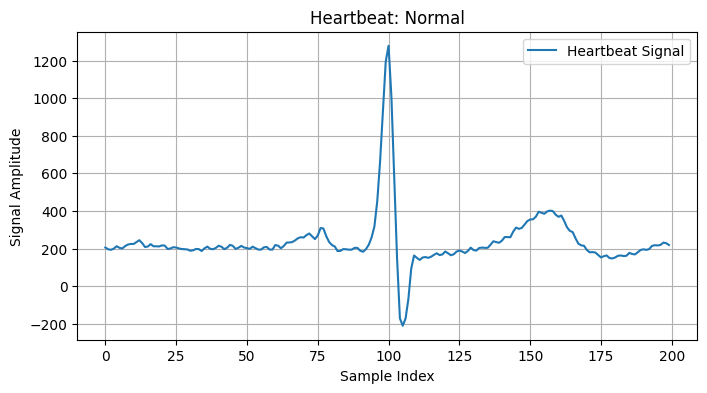

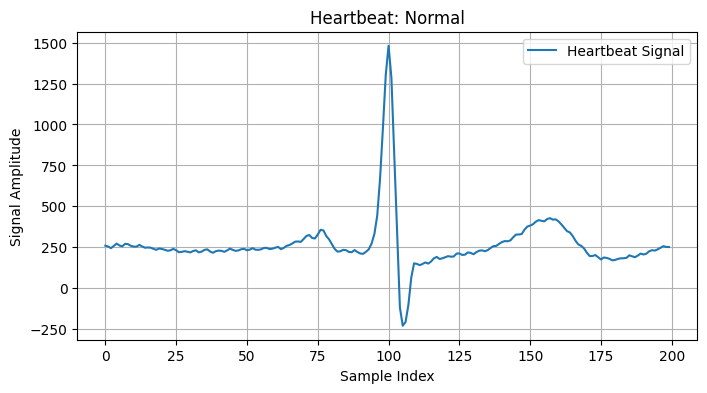

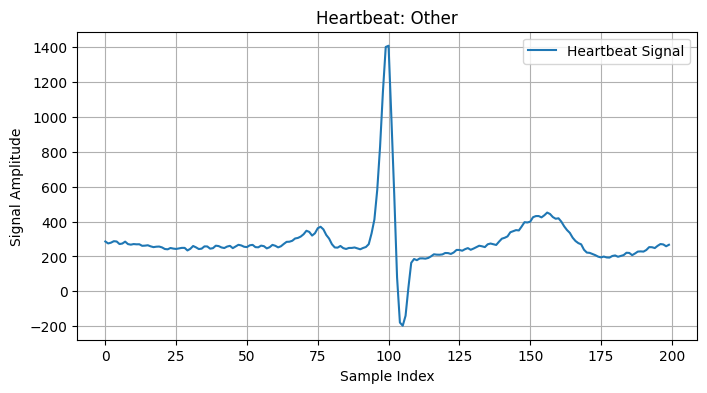

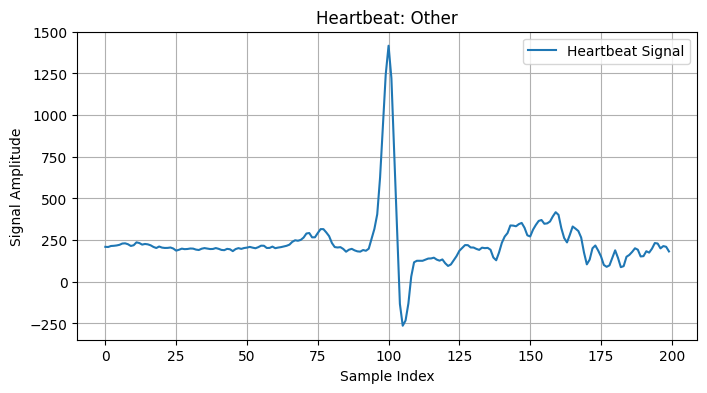

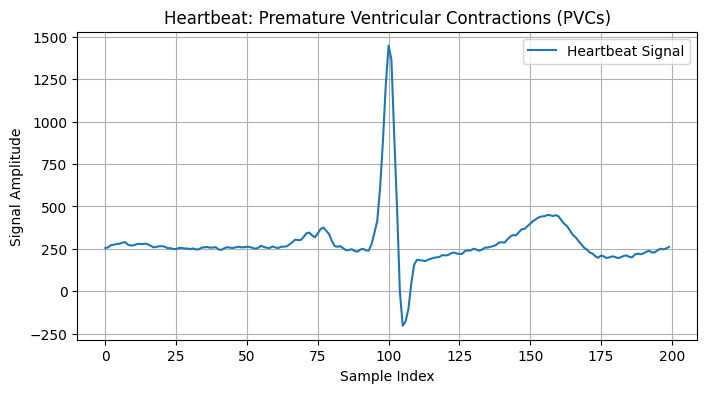

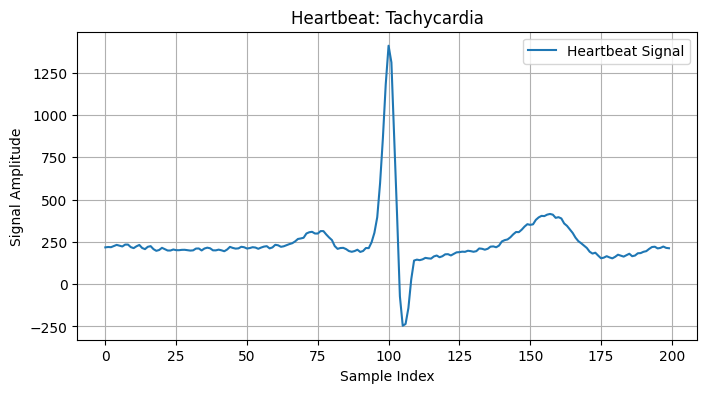

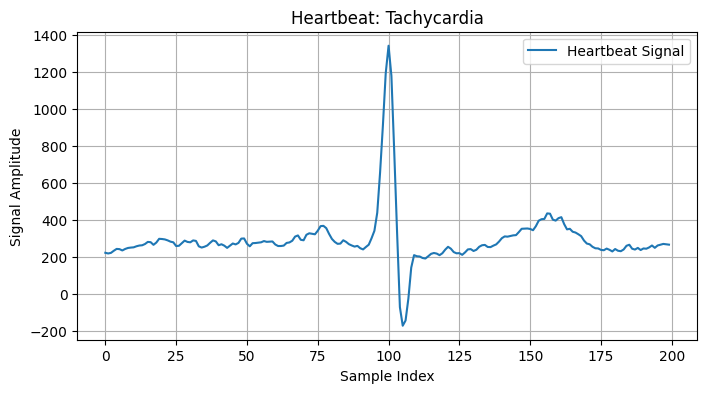

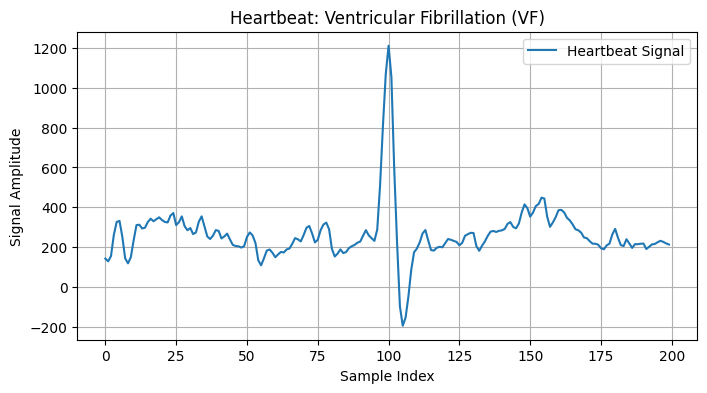

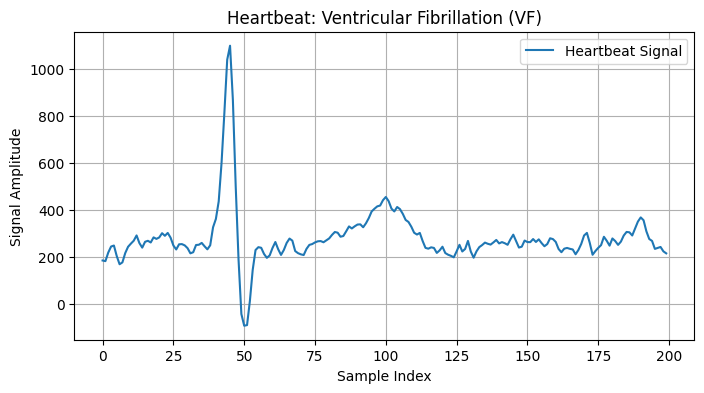

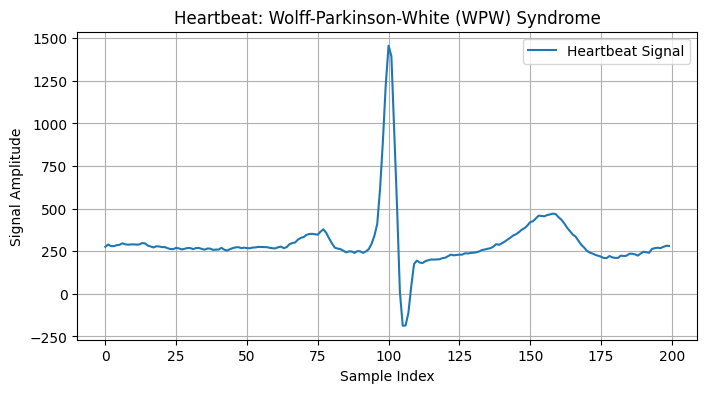

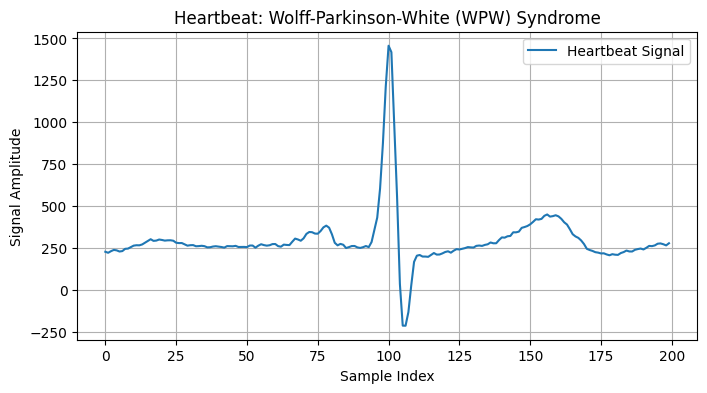

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Function to plot heartbeats for all unique classes
def plot_samples_for_all_classes(X, y, num_samples_per_class=2):
    unique_classes = np.unique(y)
    print("Unique Classes:", unique_classes)

    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]  # Get indices of heartbeats belonging to the current class
        if len(class_indices) == 0:
            print("No heartbeats found for class:", class_label)
            continue
        selected_indices = random.sample(list(class_indices), min(len(class_indices), num_samples_per_class))
        for idx in selected_indices:
            plt.figure(figsize=(8, 4))
            plt.plot(X[idx], label='Heartbeat Signal')
            plt.title('Heartbeat: ' + y[idx])
            plt.xlabel('Sample Index')
            plt.ylabel('Signal Amplitude')
            plt.legend()
            plt.grid(True)
            plt.show()

# Plot samples for all unique classes
plot_samples_for_all_classes(X_train, y_train, num_samples_per_class=2)


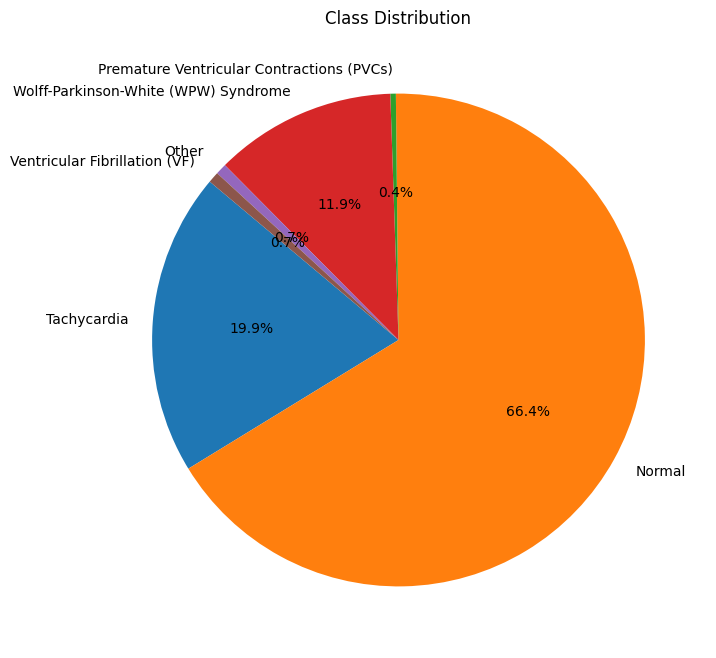

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot pie chart of class distribution
def plot_class_distribution(y):
    class_counts = {}
    for class_label in y:
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            class_counts[class_label] = 1

    labels = class_counts.keys()
    counts = class_counts.values()

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution')
    plt.show()

# Plot pie chart of class distribution
plot_class_distribution(y_train)
